In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CanineTokenizer, CanineModel, CanineConfig
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

# Define a special mask token
MASK_TOKEN = "#"  # Special character to represent masked positions

# Define the alphabet
alphabet = "abcdefghijklmnopqrstuvwxyz"
char_to_id = {char: i for i, char in enumerate(alphabet)}
id_to_char = {i: char for i, char in enumerate(alphabet)}

class MaskedWordDataset(Dataset):
    def __init__(self, word_data, tokenizer, max_length=20):
        """
        Dataset for masked word prediction.
        
        Args:
            word_data: List of tuples (masked_word, valid_chars)
                       where valid_chars is a list of possible characters
            tokenizer: CANINE tokenizer
            max_length: Maximum sequence length
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []
        self.targets = []
        
        for masked_word, valid_chars in tqdm(word_data):
            # Replace underscore with mask token
            input_word = masked_word.replace("_", MASK_TOKEN)
            self.inputs.append(input_word)
            
            # Create multi-hot encoding for valid characters
            target = torch.zeros(26)
            for char in valid_chars:
                if char in char_to_id:
                    target[char_to_id[char]] = 1.0
            self.targets.append(target)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        masked_word = self.inputs[idx]
        target = self.targets[idx]
        
        # Tokenize the input
        encoding = self.tokenizer(masked_word, 
                                  return_tensors="pt", 
                                  padding="max_length",
                                  max_length=self.max_length,
                                  truncation=True)
        
        # Find positions of mask tokens
        # Convert mask token to input_ids and find its positions
        mask_input_ids = self.tokenizer.encode(MASK_TOKEN, add_special_tokens=False)[0]
        mask_positions = (encoding.input_ids == mask_input_ids).nonzero(as_tuple=True)[1]
        
        return {
            'input_ids': encoding.input_ids.squeeze(),
            'attention_mask': encoding.attention_mask.squeeze(),
            'mask_positions': mask_positions,
            'target': target
        }

class CanineMaskedCharPredictor(nn.Module):
    def __init__(self, model_name="google/canine-s"):
        super(CanineMaskedCharPredictor, self).__init__()
        self.config = CanineConfig.from_pretrained(model_name)
        self.canine = CanineModel.from_pretrained(model_name)
        
        # Add a classifier layer to predict probabilities for 26 characters
        self.classifier = nn.Linear(self.config.hidden_size, 26)
        self.sigmoid = nn.Sigmoid()  # Use sigmoid for multi-label classification
        
    def forward(self, input_ids, attention_mask, mask_positions):
        # Get the hidden states from CANINE
        outputs = self.canine(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        
        # Extract representations at mask positions
        batch_size = input_ids.size(0)
        masked_outputs = []
        
        for i in range(batch_size):
            # Get the hidden state at the mask position for this example
            # Ensure mask_positions[i] is on the same device as hidden_states
            if isinstance(mask_positions[i], list):
                mask_pos = mask_positions[i]
            else:
                mask_pos = mask_positions[i].to(hidden_states.device)
                
            if len(mask_pos) > 0:  # Check if there's at least one mask
                masked_output = hidden_states[i, mask_pos[0]]
                masked_outputs.append(masked_output)
        
        # Stack the masked outputs
        if masked_outputs:
            masked_outputs = torch.stack(masked_outputs)
            
            # Predict character probabilities
            logits = self.classifier(masked_outputs)
            probs = self.sigmoid(logits)  # Apply sigmoid for multi-label
            
            return probs
        else:
            # Handle the case when no masks are found
            return torch.zeros((batch_size, 26), device=input_ids.device)

def train_model(model, train_dataloader, val_dataloader=None, epochs=5, learning_rate=2e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Use Binary Cross Entropy Loss for multi-label classification
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_no=0
        
        with tqdm(train_dataloader) as pbar:
            for batch in pbar:
                batch_no+=1
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                # Ensure mask_positions is also moved to the same device
                mask_positions = [pos.to(device) for pos in batch['mask_positions']]
                targets = batch['target'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask, mask_positions)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                pbar.set_postfix({
                'avg_loss': total_loss/batch_no,
                'batch_loss': loss.item()
                # 'gameOver_penality' : (incorrect_guesses-6),
                })

            avg_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Validation
        if val_dataloader:
            model.eval()
            val_loss = 0
            all_preds = []
            all_targets = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    # Ensure mask_positions is also moved to the same device
                    mask_positions = [pos.to(device) for pos in batch['mask_positions']]
                    targets = batch['target'].to(device)

                    outputs = model(input_ids, attention_mask, mask_positions)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Convert probabilities to binary predictions (threshold = 0.5)
                    binary_preds = (outputs > 0.5).float()
                    all_preds.extend(binary_preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

            avg_val_loss = val_loss / len(val_dataloader)

            # Calculate F1, precision, and recall
            f1 = f1_score(np.array(all_targets), np.array(all_preds), average='macro', zero_division=0)
            precision = precision_score(np.array(all_targets), np.array(all_preds), average='macro', zero_division=0)
            recall = recall_score(np.array(all_targets), np.array(all_preds), average='macro', zero_division=0)

            print(f"Validation Loss: {avg_val_loss:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    return model

def main(train_data):
    # Example data: (masked_word, [list_of_valid_characters])
#     train_data = [
#         ("_at", ["b", "c", "f", "h", "m", "p", "r", "s"]),  # bat, cat, fat, hat, mat, pat, rat, sat
#         ("_og", ["d", "f", "h", "j", "l"]),                 # dog, fog, hog, jog, log
#         ("_en", ["d", "h", "m", "p", "t", "w"]),            # den, hen, men, pen, ten, wen
#         ("_ip", ["d", "h", "l", "n", "r", "s", "t", "z"]),  # dip, hip, lip, nip, rip, sip, tip, zip
#         ("b_d", ["a", "e", "i", "u"]),                      # bad, bed, bid, bud
#         ("_un", ["b", "f", "g", "r", "s"]),                 # bun, fun, gun, run, sun
#         ("_ot", ["d", "g", "h", "l", "n", "p"]),            # dot, got, hot, lot, not, pot
#         ("_an", ["c", "f", "m", "p", "r", "t", "v"]),       # can, fan, man, pan, ran, tan, van
#         ("s_y", ["h", "k", "l", "p", "t"]),                 # shy, sky, sly, spy, sty
#         ("_id", ["a", "b", "h", "k", "l", "m"]),            # aid, bid, hid, kid, lid, mid
#     ]
    # Split into train/val
    np.random.seed(42)
    np.random.shuffle(train_data)
    split = int(0.8 * len(train_data))
    train_samples = train_data[:split]
    val_samples = train_data[split:]

    # Create tokenizer and datasets
    tokenizer = CanineTokenizer.from_pretrained("google/canine-s")
    print('tokenizer loaded')
    train_dataset = MaskedWordDataset(train_samples, tokenizer)
    print('train_dataset created')
    train_dataloader = DataLoader(train_dataset, batch_size=32,shuffle=True)
    print('train_dataloader done')
    val_dataset = MaskedWordDataset(val_samples, tokenizer)
    print('val_dataset created')
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    print('val_dataloader done')
    # Initialize and train model
    model = CanineMaskedCharPredictor()
    print('model initialized')
    print('training start')
    trained_model = train_model(model, train_dataloader, val_dataloader, epochs=3)
    
    # Save the model
    torch.save(trained_model.state_dict(), "canine_masked_char_predictor.pt")

In [2]:
# import pandas as pd
# df = pd.read_pickle("globalMaskDict_train.pkl")

In [6]:
# result = [(k, list(v)) for k, v in df.items()]

In [15]:
for k,v in df.items():
    print(k,v)
    break

_____________ {'q', 'i', 's', 'n', 'l', 'w', 'h', 'm', 'j', 'a', 'p', 'v', 'x', 'u', 'c', 'g', 'o', 'y', 'z', 'e', 'f', 'b', 'r', 'k', 'd', 't'}


In [16]:
mask_df = pd.DataFrame(
{
    "masks": df.keys(),
    "output": df.values(),
})

In [20]:
from tqdm import tqdm
tqdm.pandas()

In [21]:
mask_df['masklen'] = mask_df['masks'].progress_apply(lambda x: x.count("_"))
mask_df['wordlen'] = mask_df['masks'].progress_apply(lambda x: len(x))

100%|█████████████████████████████████████████████████████████| 68735413/68735413 [01:08<00:00, 997170.75it/s]


In [22]:
sorted_df = mask_df.sort_values(by=['wordlen', 'masklen'])

In [23]:
sorted_df

,masks,output,masklen,wordlen
26090043,_,"{i, c, g, p, s, r, k, d, w, h, y, m, e, f}",1,1
151938,_q,"{i, n, g}",1,2
151939,n_,"{q, i, c, a, p, r, o, v, w, m, z, f}",1,2
884476,_n,"{g, s, b, d, k, v, z, f}",1,2
884477,d_,"{u, c, p, n, o, l, r, w, h, v, y, m, z, x}",1,2
...,...,...,...,...
34766466,________p____________________,"{i, a, n, o, r, l, h, t, y, m, e}",28,29
34766530,_______o_____________________,"{i, a, p, n, r, l, h, t, y, m, e}",28,29
65950247,___________h_________________,"{i, c, a, n, o, r, l, t, y, m, e}",28,29
65950499,____o________________________,"{i, c, a, n, r, l, h, t, y, m, e}",28,29


In [25]:
sorted_df['wordlen'].value_counts()

13    9377622
14    9027478
12    8872254
15    7187917
11    7148912
16    5604870
10    5120253
17    4078556
9     3341900
18    2634438
8     1728575
19    1653352
20     940734
7      729976
21     474579
22     313206
6      249144
23      91107
5       62940
24      51183
25      12285
27      12285
4       12051
29       8188
3        1554
2          53
1           1
Name: wordlen, dtype: int64

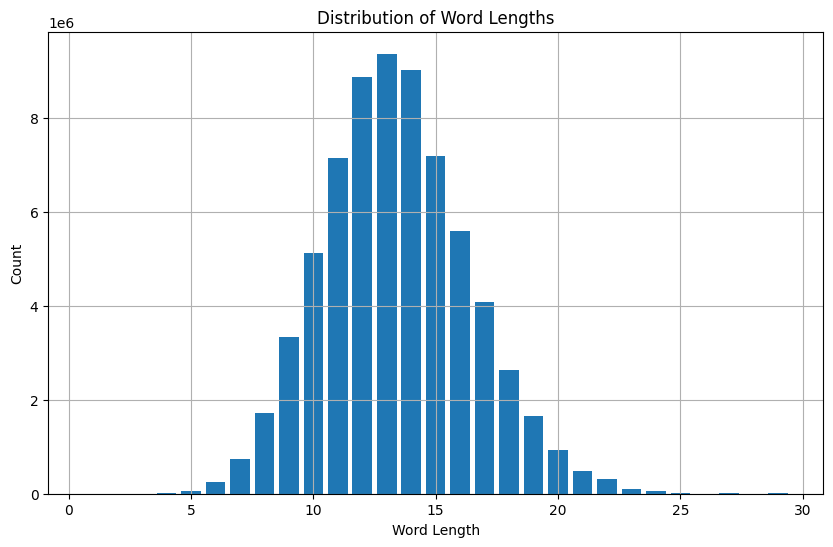

In [26]:
import matplotlib.pyplot as plt

# Assuming you already have this:
counts = sorted_df['wordlen'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Distribution of Word Lengths')
plt.grid(True)
plt.show()


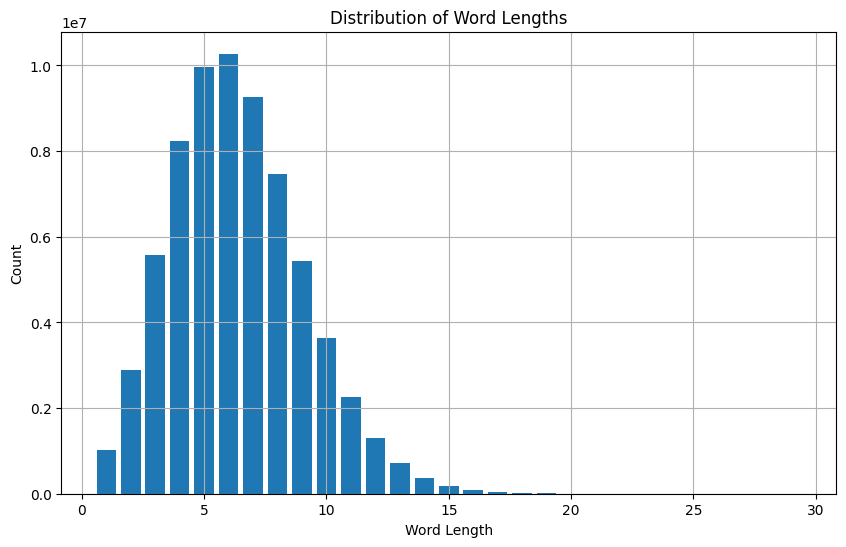

In [38]:
import matplotlib.pyplot as plt

# Assuming you already have this:
counts = sorted_df['masklen'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Distribution of Word Lengths')
plt.grid(True)
plt.show()


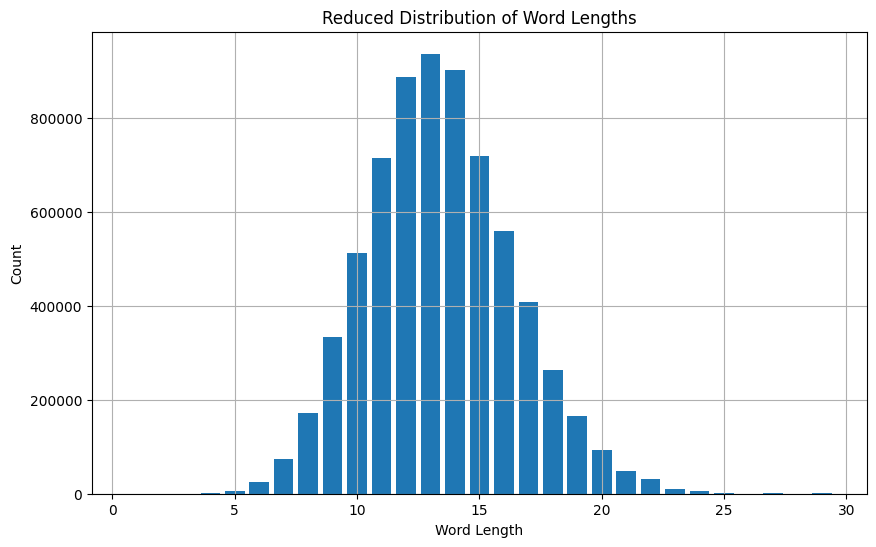

In [27]:
import matplotlib.pyplot as plt

# Assuming counts is a pandas Series with word length as index and frequency as values
reduction_fraction = 0.1  # Keep 10% of the data
reduced_counts = (counts * reduction_fraction).astype(int)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(reduced_counts.index, reduced_counts.values)
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Reduced Distribution of Word Lengths')
plt.grid(True)
plt.show()


In [28]:
reduced_counts

1          0
2          5
3        155
4       1205
5       6294
6      24914
7      72997
8     172857
9     334190
10    512025
11    714891
12    887225
13    937762
14    902747
15    718791
16    560487
17    407855
18    263443
19    165335
20     94073
21     47457
22     31320
23      9110
24      5118
25      1228
27      1228
29       818
Name: wordlen, dtype: int64

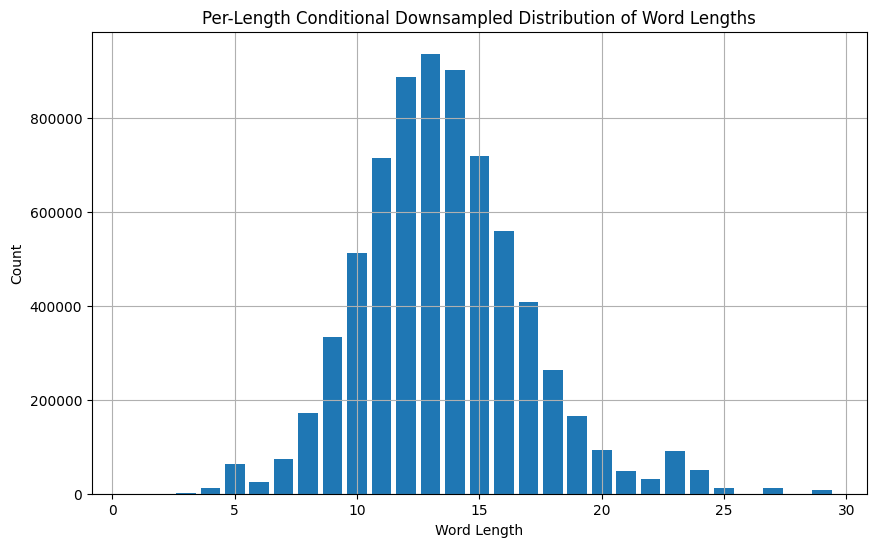

In [33]:
import matplotlib.pyplot as plt

# Set the threshold and reduction fraction
threshold = 100_000
reduction_fraction = 0.1

# Apply conditional downsampling per word length
reduced_counts = counts.apply(lambda c: int(c * reduction_fraction) if c > threshold else c)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(reduced_counts.index, reduced_counts.values)
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Per-Length Conditional Downsampled Distribution of Word Lengths')
plt.grid(True)
plt.show()


In [34]:
reduced_counts

1          1
2         53
3       1554
4      12051
5      62940
6      24914
7      72997
8     172857
9     334190
10    512025
11    714891
12    887225
13    937762
14    902747
15    718791
16    560487
17    407855
18    263443
19    165335
20     94073
21     47457
22     31320
23     91107
24     51183
25     12285
27     12285
29      8188
Name: wordlen, dtype: int64

In [35]:
def conditional_sample(group):
    if len(group) > 100_000:
        return group.sample(frac=0.1, random_state=42)  # Downsample large groups
    else:
        return group  # Keep small groups unchanged

sampled_df = mask_df.groupby('wordlen', group_keys=False).apply(conditional_sample)


In [37]:
sampled_df.wordlen.value_counts()

13    937762
14    902748
12    887225
15    718792
11    714891
16    560487
10    512025
17    407856
9     334190
18    263444
8     172858
19    165335
20     94073
23     91107
7      72998
5      62940
24     51183
21     47458
22     31321
6      24914
25     12285
27     12285
4      12051
29      8188
3       1554
2         53
1          1
Name: wordlen, dtype: int64

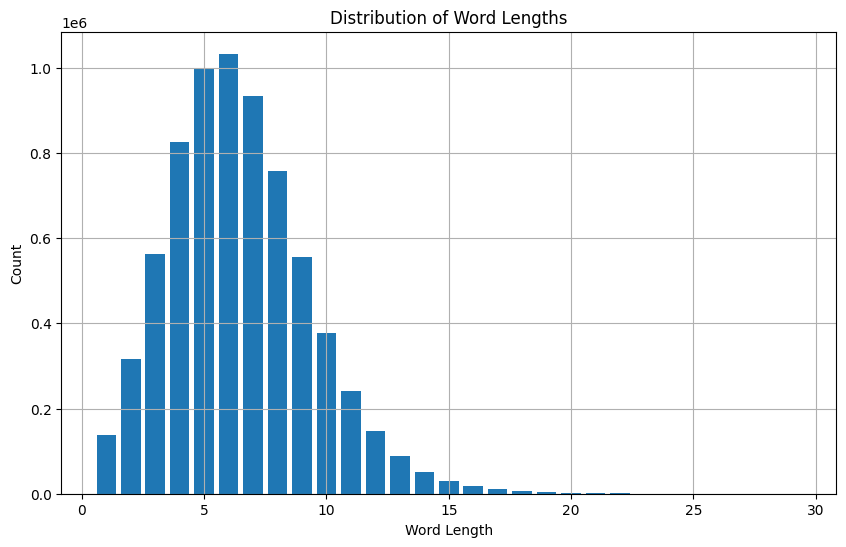

In [39]:
import matplotlib.pyplot as plt

# Assuming you already have this:
counts = sampled_df['masklen'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.title('Distribution of Word Lengths')
plt.grid(True)
plt.show()


In [24]:
sorted_df[sorted_df['wordlen']<15]

,masks,output,masklen,wordlen
26090043,_,"{i, c, g, p, s, r, k, d, w, h, y, m, e, f}",1,1
151938,_q,"{i, n, g}",1,2
151939,n_,"{q, i, c, a, p, r, o, v, w, m, z, f}",1,2
884476,_n,"{g, s, b, d, k, v, z, f}",1,2
884477,d_,"{u, c, p, n, o, l, r, w, h, v, y, m, z, x}",1,2
...,...,...,...,...
40479723,____________b_,"{i, c, a, p, s, n, o, r, l, h, t, e}",13,14
40887772,___________q__,"{u, i, c, g, a, p, s, n, o, r, k, h, l, t, y, ...",13,14
59086424,____________x_,"{u, a, r, o, l, d, h, t, y}",13,14
65470484,_____________u,"{i, c, a, s, r, k, d, h, e, f}",13,14


In [40]:
sampled_df

,masks,output,masklen,wordlen
26090043,_,"{i, c, g, p, s, r, k, d, w, h, y, m, e, f}",1,1
151937,__,"{q, i, s, n, l, h, w, m, j, a, p, v, x, u, c, ...",2,2
151938,_q,"{i, n, g}",1,2
151939,n_,"{q, i, c, a, p, r, o, v, w, m, z, f}",1,2
884476,_n,"{g, s, b, d, k, v, z, f}",1,2
...,...,...,...,...
65954333,cyclotrimet_ylenetrinitr_mine,"{h, a}",2,29
65954334,cyclotrimet_ylenetrinitramine,{h},1,29
65954335,cyclotrimethyle_etri_itr_mi_e,"{a, n}",4,29
65954336,cyclotrimethyle_etri_itrami_e,{n},3,29


In [43]:
train_data_lst = list(zip(df['masks'], df['output'].apply(list)))

KeyboardInterrupt: 

In [ ]:
train_data_lst[0]

In [45]:
train_data_lst = list(zip(sampled_df['masks'], sampled_df['output'].apply(list)))
train_data_lst[0]

('_', ['i', 'c', 'g', 'p', 's', 'r', 'k', 'd', 'w', 'h', 'y', 'm', 'e', 'f'])

In [52]:
# Example data: (masked_word, [list_of_valid_characters])
#     train_data = [
#         ("_at", ["b", "c", "f", "h", "m", "p", "r", "s"]),  # bat, cat, fat, hat, mat, pat, rat, sat
#         ("_og", ["d", "f", "h", "j", "l"]),                 # dog, fog, hog, jog, log
#         ("_en", ["d", "h", "m", "p", "t", "w"]),            # den, hen, men, pen, ten, wen
#         ("_ip", ["d", "h", "l", "n", "r", "s", "t", "z"]),  # dip, hip, lip, nip, rip, sip, tip, zip
#         ("b_d", ["a", "e", "i", "u"]),                      # bad, bed, bid, bud
#         ("_un", ["b", "f", "g", "r", "s"]),                 # bun, fun, gun, run, sun
#         ("_ot", ["d", "g", "h", "l", "n", "p"]),            # dot, got, hot, lot, not, pot
#         ("_an", ["c", "f", "m", "p", "r", "t", "v"]),       # can, fan, man, pan, ran, tan, van
#         ("s_y", ["h", "k", "l", "p", "t"]),                 # shy, sky, sly, spy, sty
#         ("_id", ["a", "b", "h", "k", "l", "m"]),            # aid, bid, hid, kid, lid, mid
#     ]
train_data = train_data_lst
# Split into train/val
np.random.seed(42)
np.random.shuffle(train_data)
split = int(0.8 * len(train_data))
train_samples = train_data[:split]
val_samples = train_data[split:]

# Create tokenizer and datasets
tokenizer = CanineTokenizer.from_pretrained("google/canine-s")
print('tokenizer loaded')
train_dataset = MaskedWordDataset(train_samples, tokenizer)
print('train_dataset created')
train_dataloader = DataLoader(train_dataset, batch_size=32,shuffle=True)
print('train_dataloader done')
val_dataset = MaskedWordDataset(val_samples, tokenizer)
print('val_dataset created')
val_dataloader = DataLoader(val_dataset, batch_size=32)
print('val_dataloader done')
# Initialize and train model
model = CanineMaskedCharPredictor()
print('model initialized')


Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


tokenizer loaded


100%|████████████████████████████████████████████████████████████| 5680019/5680019 [02:45<00:00, 34265.10it/s]


train_dataset created
train_dataloader done


100%|████████████████████████████████████████████████████████████| 1420005/1420005 [00:40<00:00, 35172.63it/s]


val_dataset created
val_dataloader done
model initialized


In [53]:
print('training start')
trained_model = train_model(model, train_dataloader, val_dataloader, epochs=3)

# Save the model
torch.save(trained_model.state_dict(), "canine_masked_char_predictor.pt")

training start


  0%|                                                                              | 0/177501 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [9] at entry 0 and [3] at entry 1

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CanineTokenizer, CanineModel, CanineConfig
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

# Define a special mask token
MASK_TOKEN = "#"  # Special character to represent masked positions

# Define the alphabet
alphabet = "abcdefghijklmnopqrstuvwxyz"
char_to_id = {char: i for i, char in enumerate(alphabet)}
id_to_char = {i: char for i, char in enumerate(alphabet)}

class MaskedWordDataset(Dataset):
    def __init__(self, word_data, tokenizer, max_length=30):
        """
        Dataset for masked word prediction.
        
        Args:
            word_data: List of tuples (masked_word, valid_chars)
                       where valid_chars is a list of possible characters
            tokenizer: CANINE tokenizer
            max_length: Maximum sequence length
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []
        self.targets = []
        
        for masked_word, valid_chars in tqdm(word_data):
            # Replace underscore with mask token
            input_word = masked_word.replace("_", MASK_TOKEN)
            self.inputs.append(input_word)
            
            # Create multi-hot encoding for valid characters
            target = torch.zeros(26)
            for char in valid_chars:
                if char in char_to_id:
                    target[char_to_id[char]] = 1.0
            self.targets.append(target)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        masked_word = self.inputs[idx]
        target = self.targets[idx]
        
        # Tokenize the input
        encoding = self.tokenizer(masked_word, 
                                  return_tensors="pt", 
                                  padding="max_length",
                                  max_length=self.max_length,
                                  truncation=True)
        
        # Find positions of mask tokens
        # Convert mask token to input_ids and find its positions
        mask_input_ids = self.tokenizer.encode(MASK_TOKEN, add_special_tokens=False)[0]
        mask_positions = (encoding.input_ids == mask_input_ids).nonzero(as_tuple=True)[1]
        
        return {
            'input_ids': encoding.input_ids.squeeze(),
            'attention_mask': encoding.attention_mask.squeeze(),
            'mask_positions': mask_positions,
            'target': target
        }

# Custom collate function to handle variable-sized mask_positions
def custom_collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    # Don't stack mask_positions, keep as a list
    mask_positions = [item['mask_positions'] for item in batch]
    targets = torch.stack([item['target'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'mask_positions': mask_positions,
        'target': targets
    }

class CanineMaskedCharPredictor(nn.Module):
    def __init__(self, model_name="google/canine-s"):
        super(CanineMaskedCharPredictor, self).__init__()
        self.config = CanineConfig.from_pretrained(model_name)
        self.canine = CanineModel.from_pretrained(model_name)
        
        # Add a classifier layer to predict probabilities for 26 characters
        self.classifier = nn.Linear(self.config.hidden_size, 26)
        self.sigmoid = nn.Sigmoid()  # Use sigmoid for multi-label classification
        
    def forward(self, input_ids, attention_mask, mask_positions):
        # Get the hidden states from CANINE
        outputs = self.canine(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        
        # Extract representations at mask positions
        batch_size = input_ids.size(0)
        masked_outputs = []
        
        for i in range(batch_size):
            # Get the hidden state at the mask position for this example
            # mask_positions is already a list of tensors
            mask_pos = mask_positions[i].to(hidden_states.device)
                
            if len(mask_pos) > 0:  # Check if there's at least one mask
                masked_output = hidden_states[i, mask_pos[0]]
                masked_outputs.append(masked_output)
            else:
                # Fallback for samples without mask (shouldn't happen but just in case)
                masked_outputs.append(hidden_states[i, 0])
        
        # Stack the masked outputs
        masked_outputs = torch.stack(masked_outputs)
            
        # Predict character probabilities
        logits = self.classifier(masked_outputs)
        probs = self.sigmoid(logits)  # Apply sigmoid for multi-label
        
        return probs

def train_model(model, train_dataloader, val_dataloader=None, epochs=5, learning_rate=2e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Use Binary Cross Entropy Loss for multi-label classification
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_no = 0
        
        with tqdm(train_dataloader) as pbar:
            for batch in pbar:
                batch_no += 1
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                # mask_positions is already a list of tensors
                mask_positions = batch['mask_positions']
                targets = batch['target'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask, mask_positions)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                pbar.set_postfix({
                    'avg_loss': total_loss/batch_no,
                    'batch_loss': loss.item()
                })

            avg_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Validation
        if val_dataloader:
            model.eval()
            val_loss = 0
            all_preds = []
            all_targets = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    # mask_positions is already a list of tensors
                    mask_positions = batch['mask_positions']
                    targets = batch['target'].to(device)

                    outputs = model(input_ids, attention_mask, mask_positions)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Convert probabilities to binary predictions (threshold = 0.5)
                    binary_preds = (outputs > 0.5).float()
                    all_preds.extend(binary_preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

            avg_val_loss = val_loss / len(val_dataloader)

            # Calculate F1, precision, and recall
            f1 = f1_score(np.array(all_targets), np.array(all_preds), average='macro', zero_division=0)
            precision = precision_score(np.array(all_targets), np.array(all_preds), average='macro', zero_division=0)
            recall = recall_score(np.array(all_targets), np.array(all_preds), average='macro', zero_division=0)

            print(f"Validation Loss: {avg_val_loss:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    return model

def main(train_data):
    # Split into train/val
    np.random.seed(42)
    np.random.shuffle(train_data)
    split = int(0.8 * len(train_data))
    train_samples = train_data[:split]
    val_samples = train_data[split:]

    # Create tokenizer and datasets
    tokenizer = CanineTokenizer.from_pretrained("google/canine-s")
    print('tokenizer loaded')
    
    train_dataset = MaskedWordDataset(train_samples, tokenizer)
    print('train_dataset created')
    
    # Use the custom collate function for the DataLoader
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True,
        collate_fn=custom_collate_fn
    )
    print('train_dataloader done')
    
    val_dataset = MaskedWordDataset(val_samples, tokenizer)
    print('val_dataset created')
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=32,
        collate_fn=custom_collate_fn
    )
    print('val_dataloader done')
    
    # Initialize and train model
    model = CanineMaskedCharPredictor()
    print('model initialized')
    print('training start')
    trained_model = train_model(model, train_dataloader, val_dataloader, epochs=3)
    
    # Save the model
    torch.save(trained_model.state_dict(), "canine_masked_char_predictor.pt")




In [ ]:
main(train_data_lst)

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


tokenizer loaded


100%|████████████████████████████████████████████████████████████| 5680019/5680019 [02:39<00:00, 35653.69it/s]


train_dataset created
train_dataloader done


100%|████████████████████████████████████████████████████████████| 1420005/1420005 [00:39<00:00, 35591.60it/s]


val_dataset created
val_dataloader done
model initialized
training start


100%|█████████████████████████████| 177501/177501 [5:09:21<00:00,  9.56it/s, avg_loss=0.229, batch_loss=0.201]


Epoch 1/3, Loss: 0.2286
Validation Loss: 0.1802, F1: 0.7039, Precision: 0.8132, Recall: 0.6438


 61%|████████████████▌          | 108813/177501 [3:11:28<1:56:10,  9.85it/s, avg_loss=0.179, batch_loss=0.162]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 64%|█████████████████▎         | 114097/177501 [3:20:48<1:53:01,  9.35it/s, avg_loss=0.179, batch_loss=0.165]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 65%|█████████████████▋         | 116054/177501 [3:24:12<1:43:46,  9.87it/s, avg_loss=0.179, batch_loss=0.167]IOPub message rate e

  0%|▏                               | 752/177501 [01:20<5:34:44,  8.80it/s, avg_loss=0.152, batch_loss=0.123]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  2%|▋                              | 4186/177501 [07:16<4:51:20,  9.91it/s, avg_loss=0.151, batch_loss=0.152]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|█▎                             | 7829/177501 [13:45<4:54:45,  9.59it/s, avg_loss=0.151, batch_loss=0.168]IOPub message rate e

 38%|██████████▋                 | 67358/177501 [1:57:19<3:06:46,  9.83it/s, avg_loss=0.148, batch_loss=0.156]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|███████████▋                 | 71191/177501 [2:04:00<2:56:46, 10.02it/s, avg_loss=0.148, batch_loss=0.11]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 41%|███████████▌                | 73349/177501 [2:07:46<3:00:05,  9.64it/s, avg_loss=0.148, batch_loss=0.154]IOPub message rate e

In [20]:

import os
os.environ['NO_PROXY'] = 'huggingface.co'
trained_model = CanineMaskedCharPredictor()
trained_model.load_state_dict(torch.load("canine_masked_char_predictor.pt"))
tokenizer = CanineTokenizer.from_pretrained("google/canine-s")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


CanineMaskedCharPredictor(
  (canine): CanineModel(
    (char_embeddings): CanineEmbeddings(
      (HashBucketCodepointEmbedder_0): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_1): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_2): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_3): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_4): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_5): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_6): Embedding(16384, 96)
      (HashBucketCodepointEmbedder_7): Embedding(16384, 96)
      (char_position_embeddings): Embedding(16384, 768)
      (token_type_embeddings): Embedding(16, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (initial_char_encoder): CanineEncoder(
      (layer): ModuleList(
        (0): CanineLayer(
          (attention): CanineAttention(
            (self): CanineSelfAttention(
              (que

In [40]:


def getPredictionForMaskedString(maskedString, guessList):
    
#     print(maskedString, guessList)
    # Test with a sample
#     test_sample = "_at"
    test_sample = maskedString
    test_input = test_sample.replace("_", MASK_TOKEN)
    encoding = tokenizer(test_input, return_tensors="pt")

    # Move test data to the appropriate device
    
    input_ids = encoding.input_ids.to(device)
    attention_mask = encoding.attention_mask.to(device)

    # Get the token ID for the mask character
    mask_input_ids = tokenizer.encode(MASK_TOKEN, add_special_tokens=False)[0]
    mask_positions = (input_ids == mask_input_ids).nonzero(as_tuple=True)[1]

    trained_model.eval()
    with torch.no_grad():
        probs = trained_model(input_ids, attention_mask, [mask_positions])
#     print(probs.shape)
    # # Get top predictions
    # values, indices = torch.topk(probs[0], 10)

    # print(f"Top predictions for '{test_sample}':")
    # for i, (prob, idx) in enumerate(zip(values, indices)):
    #     print(f"{i+1}. '{id_to_char[idx.item()]}': {prob.item():.4f}")

    # # Print the full probability vector
    # print("\nProbability vector:")
    # for i, prob in enumerate(probs[0]):
    #     print(f"{id_to_char[i]}: {prob.item():.4f}")
    prob_map = {}
    for i, prob in enumerate(probs[0]):
        prob_map[id_to_char[i]]= prob.item()
    
#     print(prob_map)
    filtered = {k: v for k, v in prob_map.items() if k not in guessList}
    max_char = max(filtered, key=filtered.get)
    
    return max_char
    
    

In [44]:
import random

# Function that selects the next guess
def guess_function(masked_word, past_guesses):
    # Naive strategy: guess most common English letters not yet guessed
    common_letters = 'etaoinshrdlcumwfgypbvkjxqz'
    for ch in common_letters:
        if ch not in past_guesses:
            return ch
    return None  # Fallback

# Function to update the masked word based on a guess
def update_masked_word(word, masked_word, guess):
    return ''.join([guess if word[i] == guess else masked_word[i] for i in range(len(word))])

# Main Hangman game loop
def play_hangman(word, guess_function, max_attempts=26):
    masked_word = '_' * len(word)
    past_guesses = []
    attempts = 0

#     print(f"Word to guess: {masked_word} (length {len(word)})")

    while masked_word != word and attempts < max_attempts:
        guess = guess_function(masked_word, past_guesses)
        if not guess or guess in past_guesses:
            print(f"Invalid or repeated guess: {guess}")
            continue

        past_guesses.append(guess)

        if guess in word:
            masked_word = update_masked_word(word, masked_word, guess)
#             print(f"Correct guess '{guess}' ➤ {masked_word}")
        else:
            attempts += 1
#             print(f"Wrong guess '{guess}' (attempt {attempts}/{max_attempts}) ➤ {masked_word}")

#     if masked_word == word:
# #         print(f"\n🎉 You guessed the word '{word}'!")
#     else:
# #         print(f"\n❌ Out of attempts! The word was '{word}'.")
    return attempts
    


In [46]:
selected_word = 'tower'


6

100%|████████████████████████████████████████████████████████████| 227300/227300 [00:00<00:00, 1985102.44it/s]


word length of 3


100%|███████████████████████████████████████████████████████████████████████| 661/661 [02:38<00:00,  4.16it/s]


total test words: 661
total wins: 48


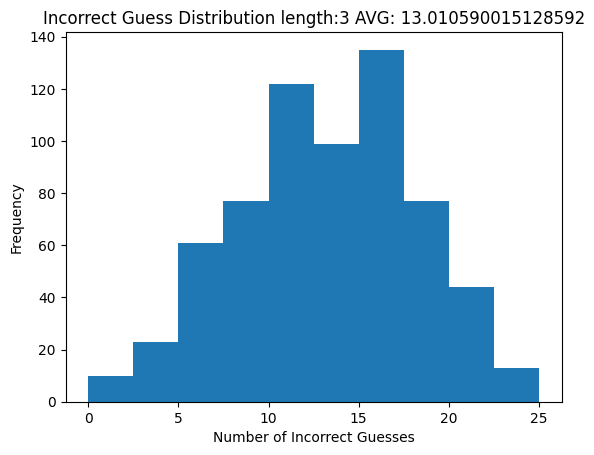

word length of 6


100%|█████████████████████████████████████████████████████████████████████| 5863/5863 [20:24<00:00,  4.79it/s]


total test words: 5863
total wins: 1509


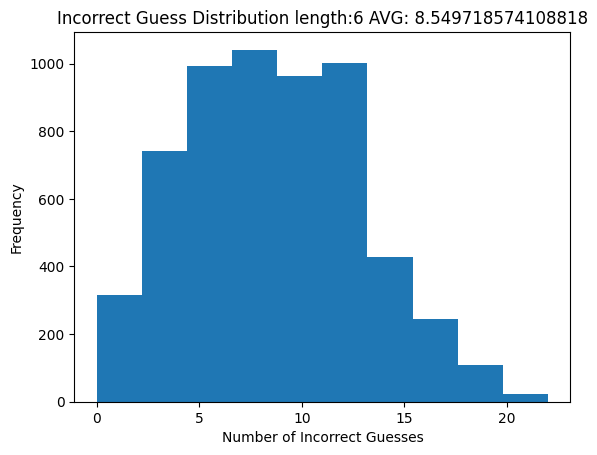

word length of 4


100%|█████████████████████████████████████████████████████████████████████| 1587/1587 [05:29<00:00,  4.81it/s]

total test words: 1587
total wins: 235


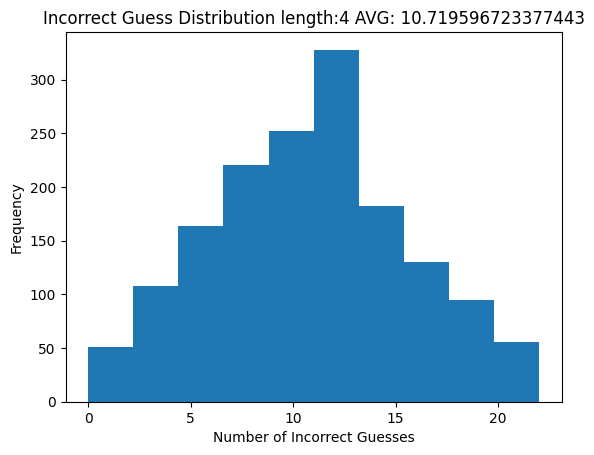

word length of 5


100%|█████████████████████████████████████████████████████████████████████| 3383/3383 [11:46<00:00,  4.79it/s]

total test words: 3383
total wins: 603


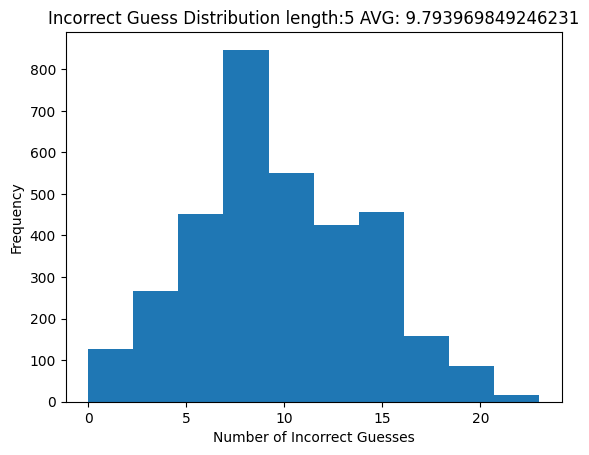

word length of 8


100%|█████████████████████████████████████████████████████████████████████| 9136/9136 [33:20<00:00,  4.57it/s]

total test words: 9136
total wins: 3713


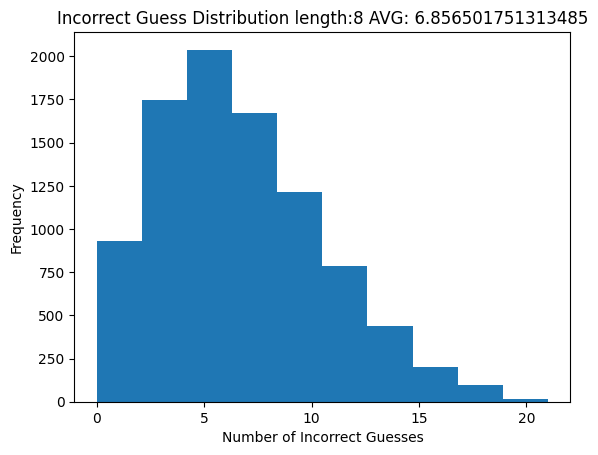

word length of 7


100%|█████████████████████████████████████████████████████████████████████| 7785/7785 [27:46<00:00,  4.67it/s]

total test words: 7785
total wins: 2527


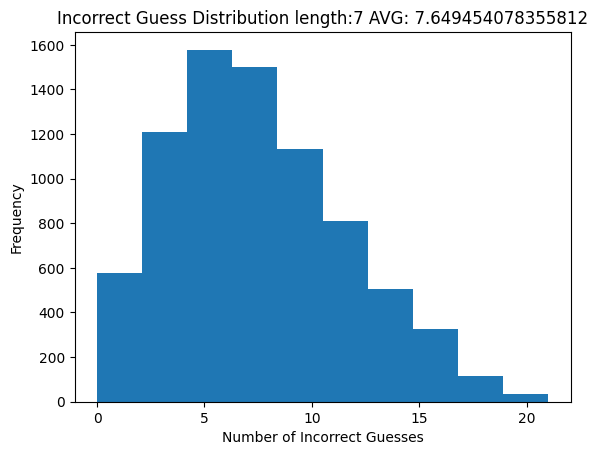

word length of 10


100%|█████████████████████████████████████████████████████████████████████| 8086/8086 [27:57<00:00,  4.82it/s]


total test words: 8086
total wins: 5165


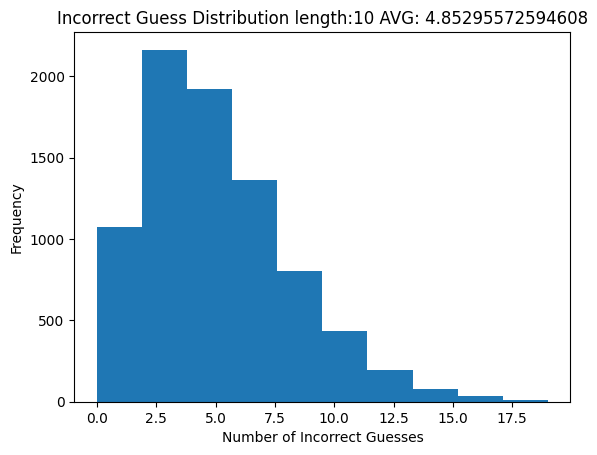

word length of 9


100%|█████████████████████████████████████████████████████████████████████| 9272/9272 [31:27<00:00,  4.91it/s]


total test words: 9272
total wins: 4776


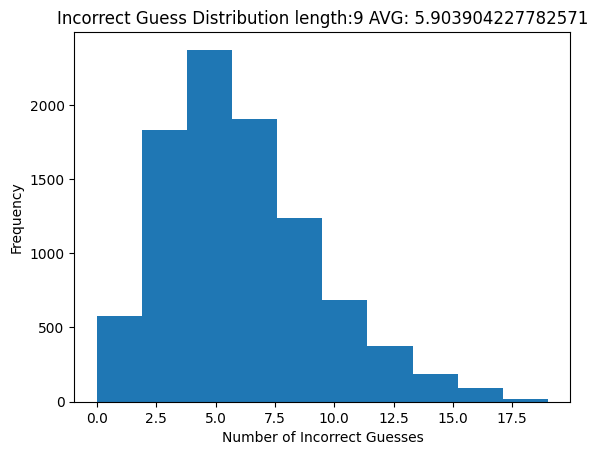

word length of 11


100%|█████████████████████████████████████████████████████████████████████| 6836/6836 [21:37<00:00,  5.27it/s]

total test words: 6836
total wins: 4991


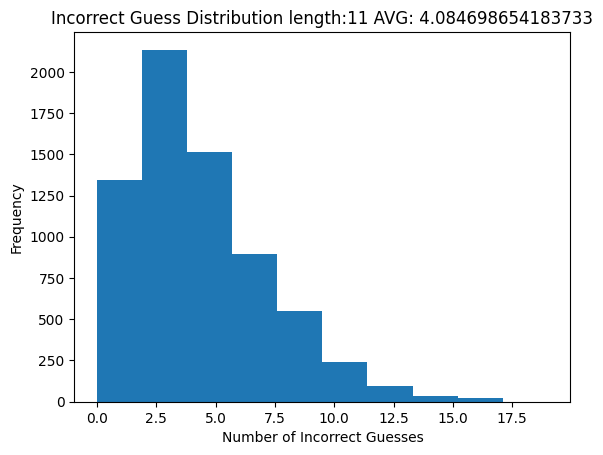

word length of 12


100%|█████████████████████████████████████████████████████████████████████| 5454/5454 [17:49<00:00,  5.10it/s]


total test words: 5454
total wins: 4444


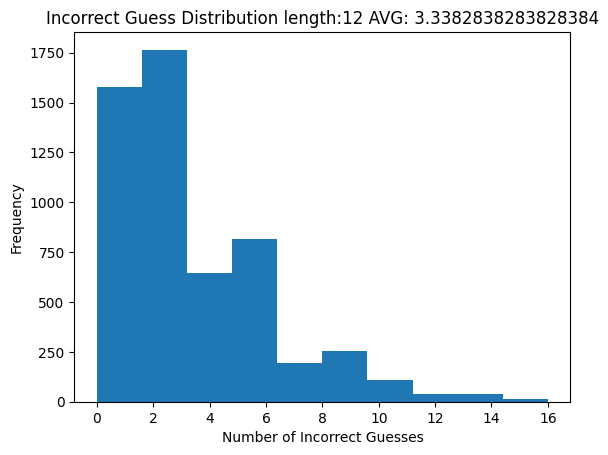

word length of 13


100%|█████████████████████████████████████████████████████████████████████| 3887/3887 [12:15<00:00,  5.29it/s]


total test words: 3887
total wins: 3317


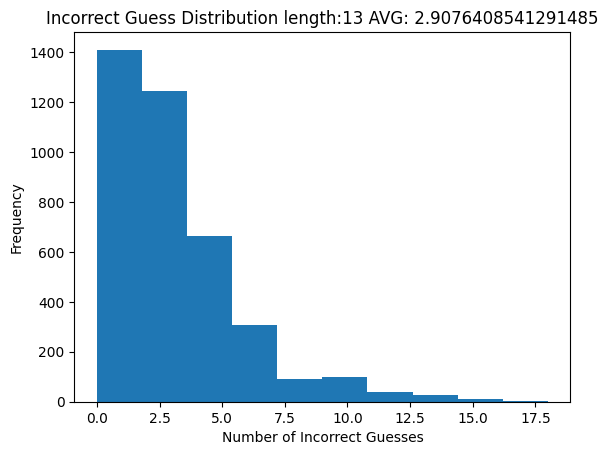

word length of 15


100%|█████████████████████████████████████████████████████████████████████| 1564/1564 [04:48<00:00,  5.42it/s]


total test words: 1564
total wins: 1471


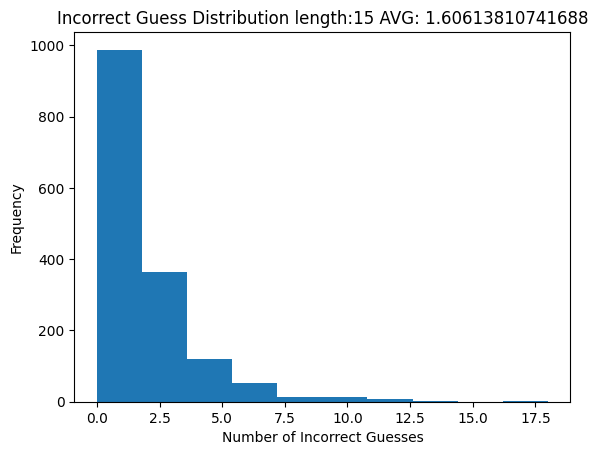

word length of 14


100%|█████████████████████████████████████████████████████████████████████| 2613/2613 [07:52<00:00,  5.53it/s]

total test words: 2613
total wins: 2448


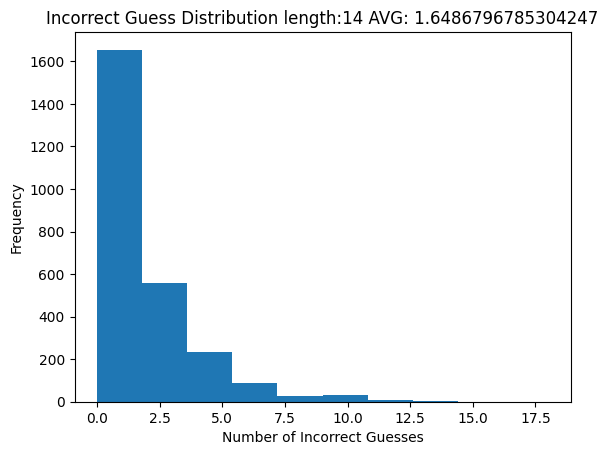

word length of 20


100%|█████████████████████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]


total test words: 68
total wins: 67


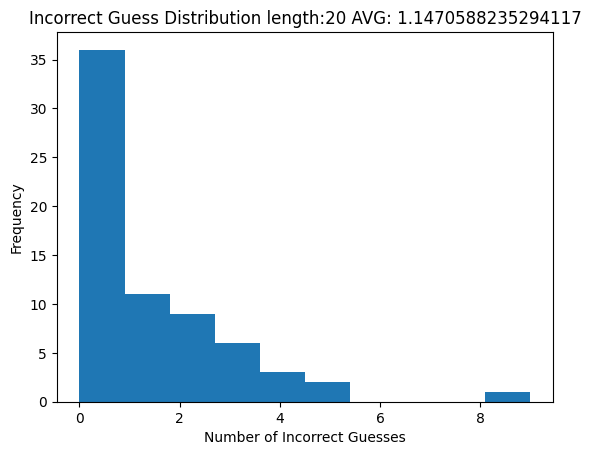

word length of 17


100%|███████████████████████████████████████████████████████████████████████| 533/533 [01:40<00:00,  5.31it/s]


total test words: 533
total wins: 512


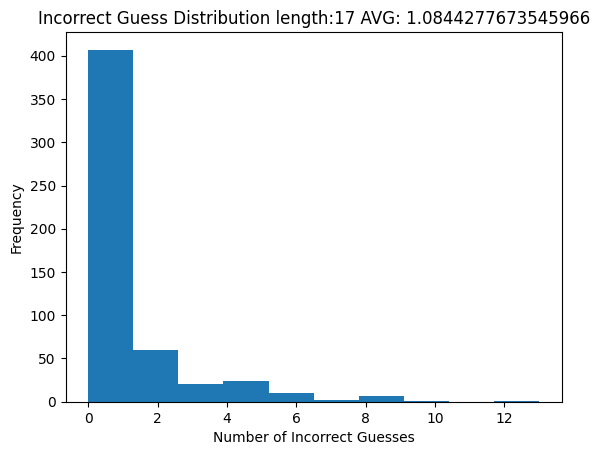

word length of 16


100%|███████████████████████████████████████████████████████████████████████| 943/943 [03:14<00:00,  4.86it/s]

total test words: 943
total wins: 909


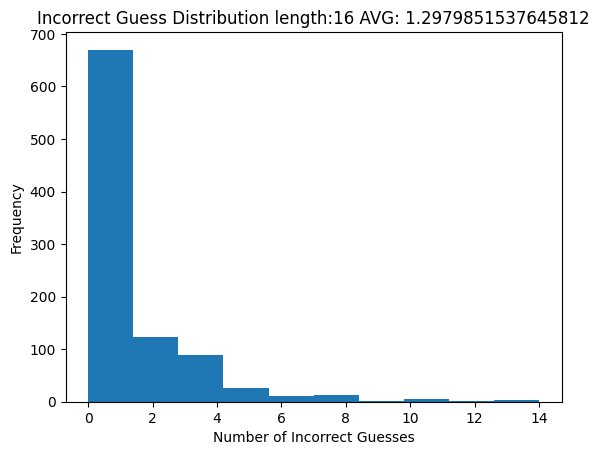

word length of 2


100%|█████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.61it/s]

total test words: 80
total wins: 9


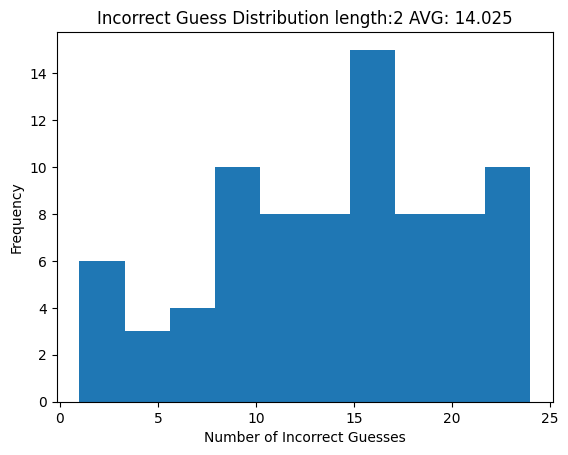

word length of 21


100%|█████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.24it/s]

total test words: 30
total wins: 29


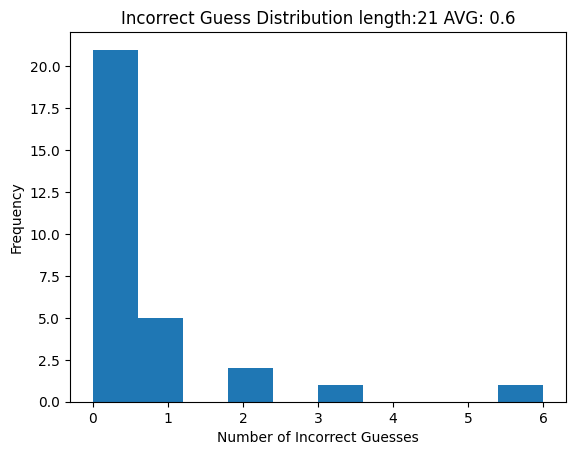

word length of 18


100%|███████████████████████████████████████████████████████████████████████| 258/258 [00:53<00:00,  4.83it/s]

total test words: 258
total wins: 255


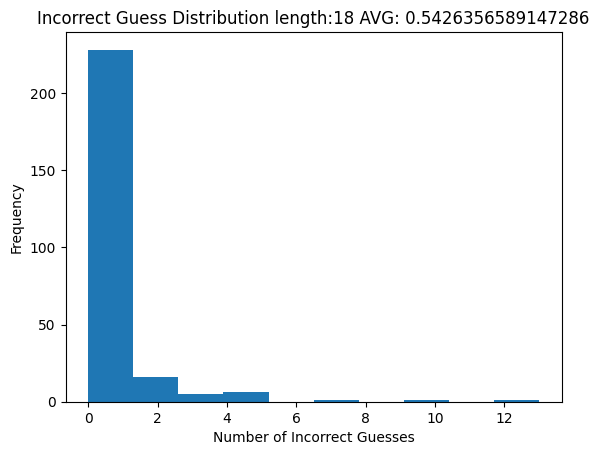

word length of 19


100%|███████████████████████████████████████████████████████████████████████| 133/133 [00:26<00:00,  5.10it/s]

total test words: 133
total wins: 127


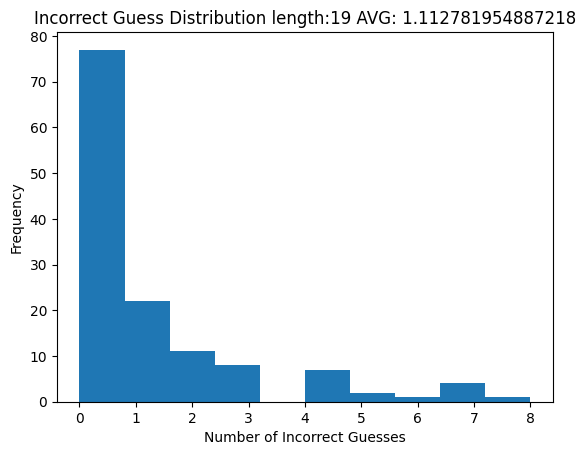

word length of 25


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]

total test words: 1
total wins: 1


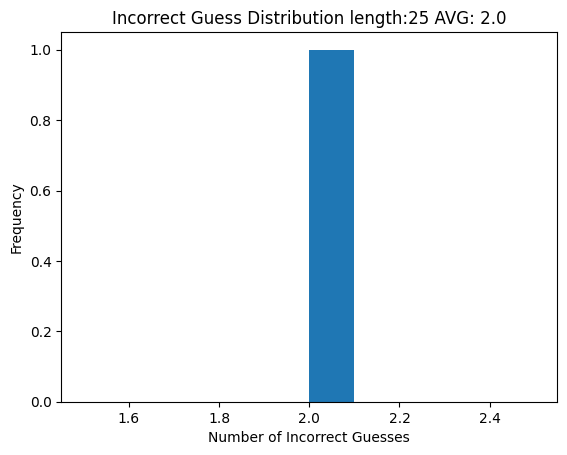

word length of 22


100%|█████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.74it/s]

total test words: 14
total wins: 14


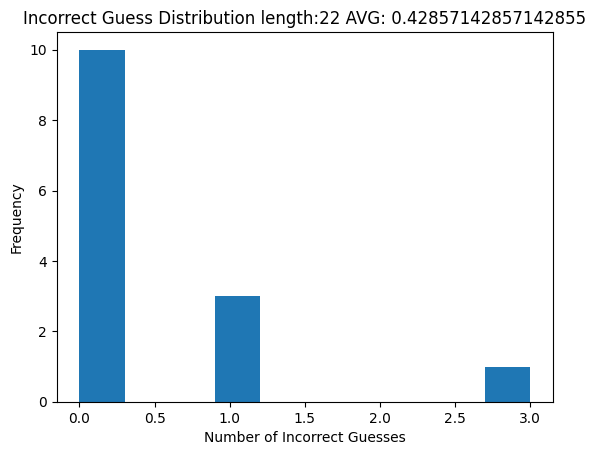

word length of 1


  0%|                                                                                   | 0/6 [00:00<?, ?it/s]


RuntimeError: Given input size: (1x1x3). Calculated output size: (1x1x0). Output size is too small

In [48]:
# from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from src.dataset import HangmanTestDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

# Set the seed for reproducibility
SEED = 42
random.seed(SEED)

# Read and clean words
with open('words_250000_train.txt', 'r') as file:
    training_words = [line.strip().lower() for line in file if line.strip().isalpha()]

# Group words by their lengths
word_dict_by_len = {}
for word in tqdm(training_words):
    l = len(word)
    word_dict_by_len.setdefault(l, []).append(word)



model.eval()
total_wins = 0

# To store the results length wise
incorrectGuessesDict = dict()

for word_length, word_list in word_dict_by_len.items():
    print(f'word length of {word_length}')
    
    random.shuffle(word_list)
    split_idx = int(0.7 * len(word_list))
    test_dataset = word_list[split_idx:]
    
    incorrectGuessesList = []
    for selected_word in tqdm(test_dataset):
        incorrectGuesses = play_hangman(selected_word, getPredictionForMaskedString)
        incorrectGuessesList.append(incorrectGuesses)
    
    incorrectGuessesDict[word_length] = incorrectGuessesList
    wins = sum(1 for num in incorrectGuessesList if num < 6)
    total_wins +=wins
    print(f'total test words: {len(incorrectGuessesList)}')
    print(f'total wins: {wins}')
    
    
    plt.hist(incorrectGuessesList)
    plt.title(f"Incorrect Guess Distribution length:{word_length} AVG: {np.mean(incorrectGuessesList)}")
    plt.xlabel("Number of Incorrect Guesses")
    plt.ylabel("Frequency")
    plt.show()

print(total_wins)
with open(f'results.pkl', 'wb') as f:
    pickle.dump(incorrectGuessesDict, f)

In [55]:
37180/68204

0.5451293179285672

word length of 23


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]

total test words: 5
total wins: 5


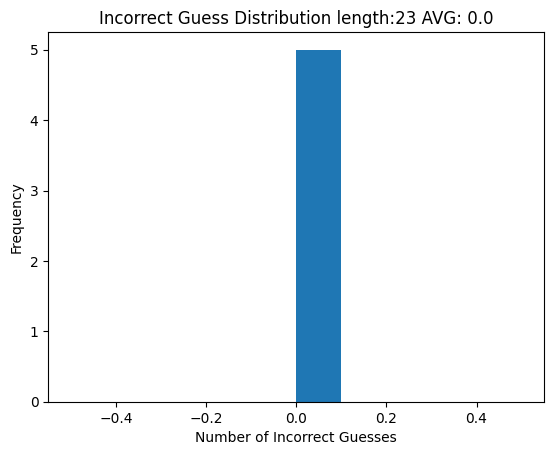

word length of 29


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]

total test words: 1
total wins: 1


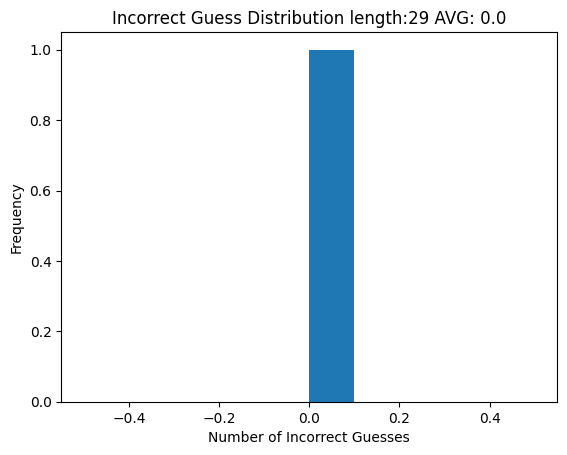

word length of 24


100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


total test words: 3
total wins: 3


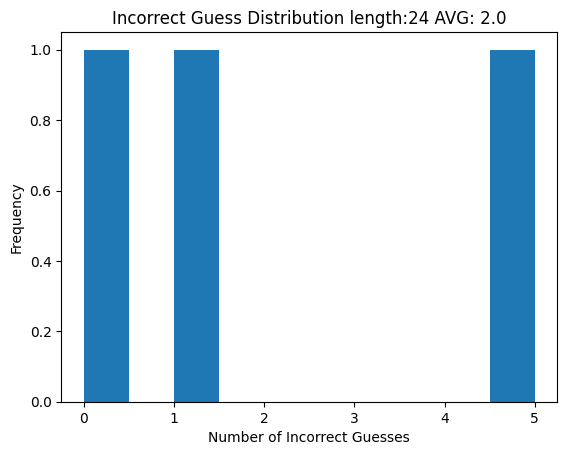

word length of 28


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

total test words: 1
total wins: 0


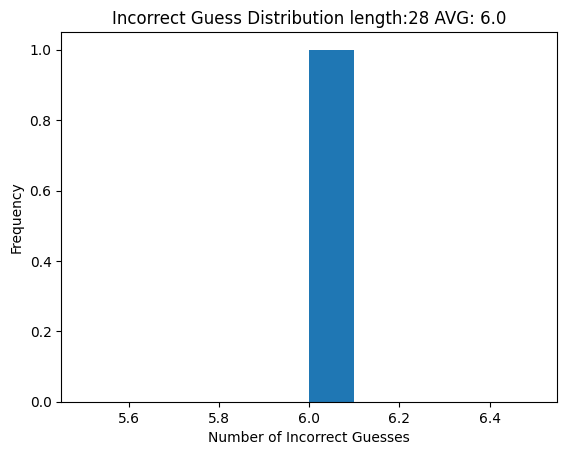

word length of 27


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]

total test words: 1
total wins: 1


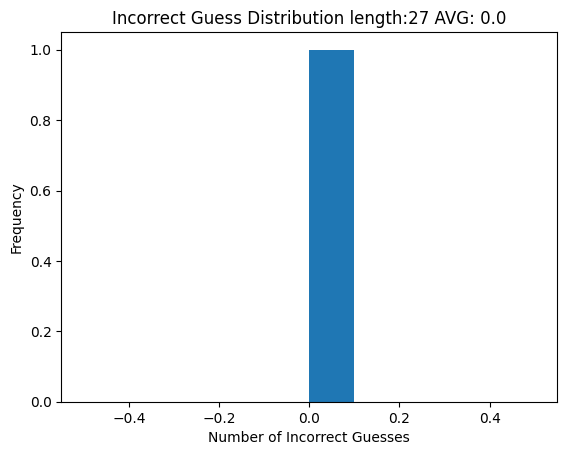

In [53]:
# left=[23,29,24,28,27]
for word_length, word_list in word_dict_by_len.items():
    if(word_length not in left):
        continue
    print(f'word length of {word_length}')
    
    random.shuffle(word_list)
    split_idx = int(0.7 * len(word_list))
    test_dataset = word_list[split_idx:]
    
    incorrectGuessesList = []
    for selected_word in tqdm(test_dataset):
        incorrectGuesses = play_hangman(selected_word, getPredictionForMaskedString)
        incorrectGuessesList.append(incorrectGuesses)
    
    incorrectGuessesDict[word_length] = incorrectGuessesList
    wins = sum(1 for num in incorrectGuessesList if num < 6)
    total_wins +=wins
    print(f'total test words: {len(incorrectGuessesList)}')
    print(f'total wins: {wins}')
    
    
    plt.hist(incorrectGuessesList)
    plt.title(f"Incorrect Guess Distribution length:{word_length} AVG: {np.mean(incorrectGuessesList)}")
    plt.xlabel("Number of Incorrect Guesses")
    plt.ylabel("Frequency")
    plt.show()

In [62]:
print(total_wins)
with open(f'results.pkl', 'wb') as f:
    pickle.dump(incorrectGuessesDict, f)

37180


length: 1  support: 6   Wins = 1   Losses = 5  win% = 16.666666666666664

length: 2  support: 80   Wins = 9   Losses = 71  win% = 11.25

length: 3  support: 661   Wins = 48   Losses = 613  win% = 7.2617246596066565

length: 4  support: 1587   Wins = 235   Losses = 1352  win% = 14.807813484562066

length: 5  support: 3383   Wins = 603   Losses = 2780  win% = 17.82441619864026

length: 6  support: 5863   Wins = 1509   Losses = 4354  win% = 25.737676957189155

length: 7  support: 7785   Wins = 2527   Losses = 5258  win% = 32.45985870263327

length: 8  support: 9136   Wins = 3713   Losses = 5423  win% = 40.64141856392294

length: 9  support: 9272   Wins = 4776   Losses = 4496  win% = 51.509922346850736

length: 10  support: 8086   Wins = 5165   Losses = 2921  win% = 63.87583477615632

length: 11  support: 6836   Wins = 4991   Losses = 1845  win% = 73.01053247513165

length: 12  support: 5454   Wins = 4444   Losses = 1010  win% = 81.48148148148148

length: 13  support: 3887   Wins = 3317   

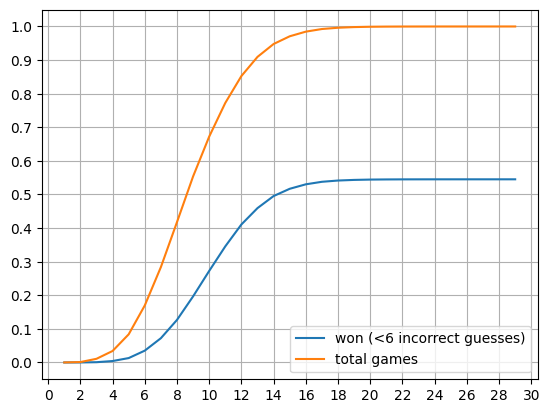

In [63]:
import pickle
with open(f'results.pkl', 'rb') as f:
    loaded_data = pickle.load(f)



# for wordLen, inc_gues in loaded_data['incorrectGuessesDict'].items():
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
    
total_test_samples = 68204
word_lengths =  loaded_data.keys()
word_lengths = sorted(word_lengths)
for wordLen in word_lengths:
    inc_gues = loaded_data[wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    print(f'length: {wordLen}  support: {total_words}   Wins = {wins}   Losses = {total_words-wins}  win% = {wins/total_words*100}\n')
    
    
winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = loaded_data[wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    if(wordLen == 1):
        totalList.append(total_words)
        winsList.append(wins)
    else:
        totalList.append(totalList[-1] + total_words)
        winsList.append(winsList[-1]+ wins)

for i in range(len(winsList)):
    winsList[i] = winsList[i]/total_test_samples
    totalList[i] = totalList[i]/total_test_samples
plt.plot(word_lengths, winsList, label='won (<6 incorrect guesses)')
plt.plot(word_lengths, totalList, label='total games')
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.legend()
    

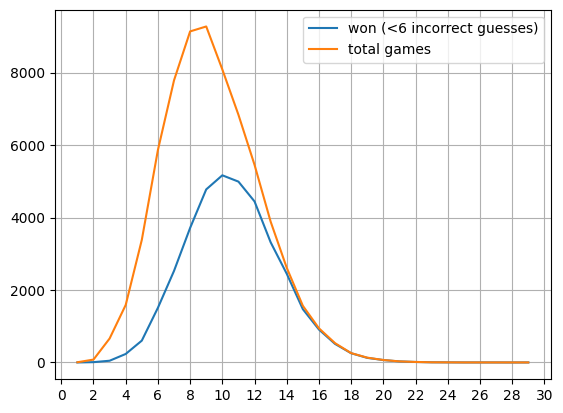

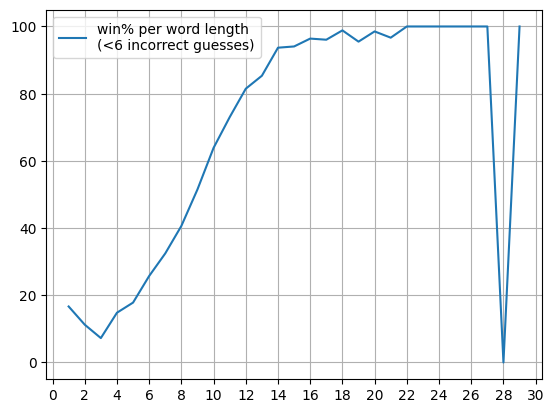

In [64]:
# for wordLen, inc_gues in loaded_data['incorrectGuessesDict'].items():
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
    
winsList=[]
totalList=[]
for wordLen in word_lengths:
    inc_gues = loaded_data[wordLen]
    total_words = len(inc_gues)
    wins = sum(1 for num in inc_gues if num < 6)
    totalList.append(total_words)
    winsList.append(wins)

# for i in range(len(winsList)):
#     winsList[i] = winsList[i]/total_test_samples
#     totalList[i] = totalList[i]/total_test_samples
plt.plot(word_lengths, winsList, label='won (<6 incorrect guesses)')
plt.plot(word_lengths, totalList, label='total games')
# plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.legend()
plt.show()

plt.plot(word_lengths, [i*100/j for i,j  in zip(winsList,totalList)], label='win% per word length\n(<6 incorrect guesses)')
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.grid(True)
plt.legend()
plt.show()